In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
from scipy.special import logsumexp
import emcee
import corner

In [3]:
t_min_ogle, tE_ogle, u_min_ogle, fbl_ogle, m_tot_ogle = 2456724.643, 42.837, 0.148, 0.887, 15.350

#t_min, tE, u_min, fbl, m_tot = 0, 0, 0, 0, 0
#par = t_min, tE, u_min, fbl, m_tot

t_min_sx, t_min_dx = 2456500 ,  2457000
tE_sx, tE_dx = 20, 60
u_min_sx, u_min_dx = 0.0, 0.3
fbl_sx, fbl_dx = 0.0 , 2.0
m_tot_sx, m_tot_dx = 13.0 , 16

In [4]:
data = Table.read("ftp://ftp.astrouw.edu.pl/ogle/ogle4/ews/2014/blg-0021/phot.dat", format = "ascii")

In [5]:
ts_grezzo = data['col1']
ms_grezzo = data['col2']
ms_err_grezzo = data['col3']

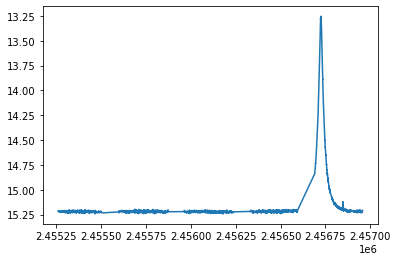

In [6]:
plt.plot(ts_grezzo, ms_grezzo);
plt.gca().invert_yaxis()

In [7]:
t_rif = 2456400

In [8]:
mask = [(ts_grezzo > t_rif)]

In [9]:
ts = ts_grezzo[tuple(mask)]
ms = ms_grezzo[tuple(mask)]
ms_err = ms_err_grezzo[tuple(mask)]

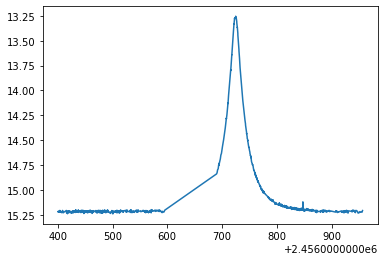

In [10]:
plt.plot(ts, ms);
plt.gca().invert_yaxis()

In [11]:
def u2(t, umin, t0, tE):
    return umin**2 + ((t - t0)/ tE)**2

def magnification(u2):
    return (u2 + 2) / (np.sqrt(u2*(u2 + 4))) 

def log_likelihood(par, ts, ms, ms_err): # probabilità dei dati rispettino il modello dati i parametri (par)
    # le somme sono piu veloci dei prodotti quindi faccio la log lakilood
    # è una guassiana perchè il modello rappresenta una gaussiana...
    # nell'espereinza scorsa il modello era un esponenziale e quindi la likelohood era un esponenziale.
    
    t_min, tE, u_min, fbl, m_tot = par
    
    model = m_tot - 2.5*np.log10(fbl*magnification(u2(ts, u_min, t_min, tE)) + 1 - fbl)
    
    return ( - 0.5 * np.sum( np.log(2*np.pi*ms_err**2) + (( ms - model ) / ms_err )**2) ) 

# t_min_sx è definito fuori dalla funzione, ma lui lo capisce comunque.
def log_prior (par): # probabilità che i parametri stanno in un intervallo di valroi.
    
    t_min, tE, u_min, fbl, m_tot = par
    
    if t_min < t_min_sx or t_min > t_min_dx or tE < tE_sx or tE > tE_dx or u_min < u_min_sx or u_min > u_min_dx or fbl < fbl_sx  or fbl > fbl_dx or m_tot < m_tot_sx or m_tot > m_tot_dx:
        return -np.inf
    else:
        return -np.log((t_min_dx - t_min_sx)*(tE_dx - tE_sx)*(u_min_dx - u_min_sx )*(fbl_dx - fbl_sx)*(m_tot_dx - m_tot_sx ))
    
def log_posterior (par, xs, ys, sigmas): # probabilità che i parametri rispettino il modello, dato il fatto
    # che ho i dati.
    lp = log_prior(par)
    
    if np.isfinite(lp):
        return lp + log_likelihood(par, ts, ms, ms_err)
    else:
        return lp

In [12]:
pos_iniziale = np.array([ np.random.uniform( t_min_sx, t_min_dx ), np.random.uniform( tE_sx, tE_dx ), np.random.uniform( u_min_sx, u_min_dx ), np.random.uniform( fbl_sx, fbl_dx ), np.random.uniform( m_tot_sx, m_tot_dx ) ])

In [13]:
pos_iniziale

array([2.45668456e+06, 3.45842521e+01, 4.98848198e-02, 1.81872209e+00,
       1.49404348e+01])

In [14]:
# mu + sigma * np.random.randn(...)
pos = pos_iniziale + 1e-4 * np.random.randn(25, 5) # perche questa cosa?
# comunque quello che fa LA RIGA è creare una matrice 25 righe e 5 colonne con numeri distribuiti intorno al 
# valore medio pos_iniziale.

nwalkers, ndim = pos.shape # pos.shape = 25, 5

sampler = emcee.EnsembleSampler( # i sempler cosa sono??? Anzitutto sono di dimensione 5.
    #Credo che siano dei numeri che piano piano dovrebbero
    # convergere ad un valore. 
    nwalkers, ndim, log_posterior, args=(ts, ms, ms_err)
)
sampler.run_mcmc(pos, 5000, progress=True); # 5000 è il numero di vettori per il singolo parametro

100%|██████████| 5000/5000 [00:50<00:00, 98.23it/s] 


In [15]:
samples[:, :, 0] # matrice con 5000 righe e 25 colonne riferita al tempo t_min
# le colonne sono ogni camminatore. Ovvero ogni camminatore percorre un percorso e mi fornisce 5000 dati di t_min

NameError: name 'samples' is not defined

In [89]:
samples[0, :, 0] # questo non ha molto senso poichè prendo solo la prima posizione di ogni cammiantore.
# Il primo camminatore alla prima sua posizione mi da 15.21938557...il secondo camminatore alla prima posizione
# mi da 5.21937497 eccetera.

array([2456881.47187963, 2456881.47237485, 2456881.47214343,
       2456881.4718992 , 2456881.47207589, 2456881.47185211,
       2456881.47200663, 2456881.47201634, 2456881.47212168,
       2456881.47207689, 2456881.4722824 , 2456881.47194198,
       2456881.47209138, 2456881.47204213, 2456881.4721286 ,
       2456881.47165928, 2456881.47190922, 2456881.47208998,
       2456881.47183946, 2456881.47194965, 2456881.47211453,
       2456881.47214967, 2456881.4717756 , 2456881.47190405,
       2456881.47193807])

In [90]:
samples[:, 0, 0] # questa cosa qui mi fornisce tutte le posizioni del camminaotre 0.

array([2456881.47187963, 2456881.47187963, 2456881.4718859 , ...,
       2456976.01086729, 2456976.01086729, 2456976.01086729])

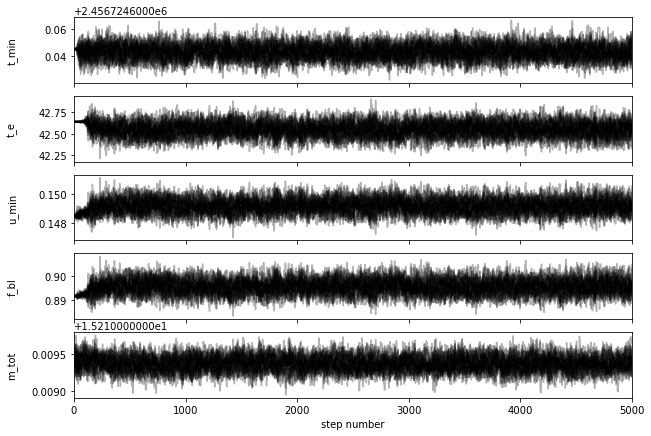

In [47]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()

labels = ["t_min", "t_e", "u_min", "f_bl", "m_tot"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    # stiamo plottando come ascisse la posizione di un singolo camminatore (5000 posizioni) e sulle 
    # orodinate stiamo plottando i diversi cammiantori. Notiamo come tutti i camminatori convergono ad un numero
    ax.set_xlim(0, 5000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [17]:
pos_iniziale = np.array([samples[4999,8,0], samples[4999,8,1], samples[4999,8,2], samples[4999,8,3], samples[4999,8,4]])

# samples[4999,8,0] prende l'ultima posizione dell'ottavo camminatore per t_min

pos = pos_iniziale + 1e-5 * np.random.randn(25, 5)
nwalkers, ndim = pos.shape


sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(ts, ms, ms_err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:52<00:00, 94.45it/s] 


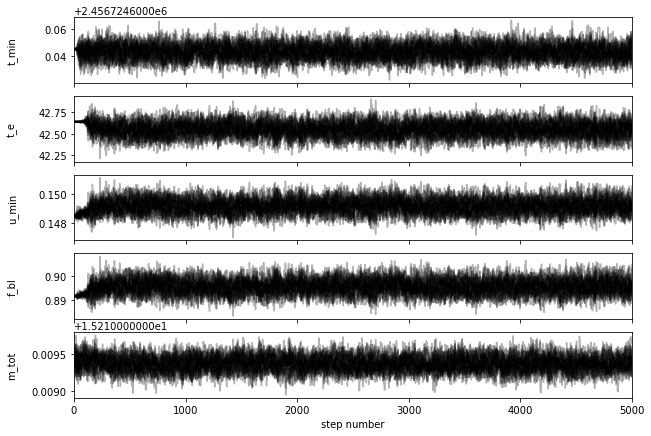

In [18]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()

labels = ["t_min", "t_e", "u_min", "f_bl", "m_tot"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 5000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

122500


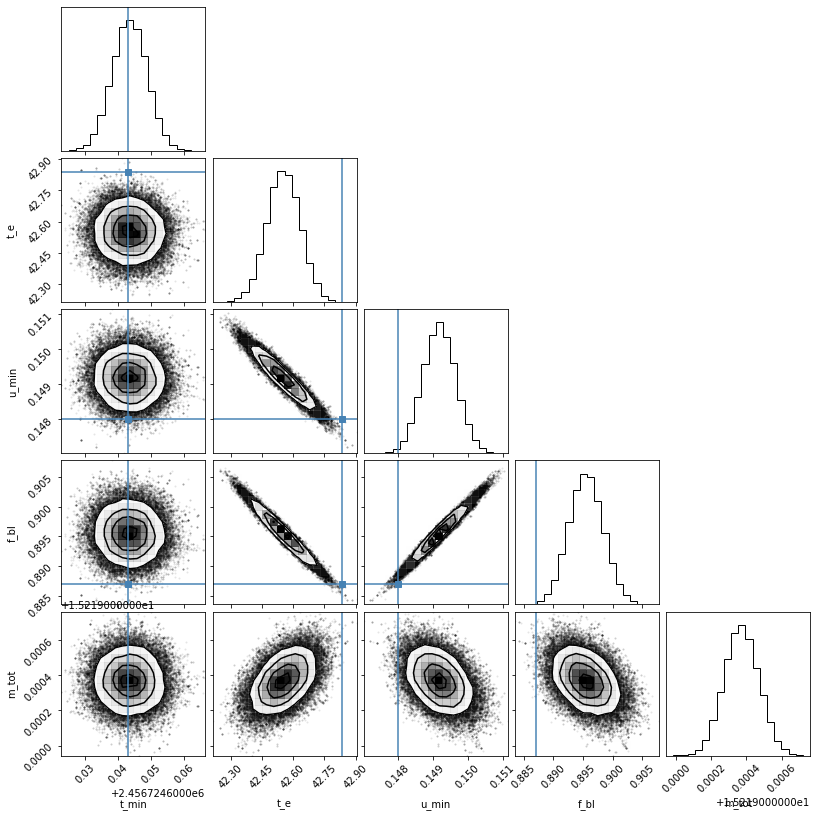

In [49]:

flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)

print(len(flat_samples)) #sono i parametri che vedo nel grafico del rumore

fig = corner.corner(
    flat_samples, labels=labels, truths=[t_min_ogle, tE_ogle, u_min_ogle, fbl_ogle, m_tot_ogle ]
);


In [22]:
sampler.get_autocorr_time()

array([59.79850588, 69.38053597, 66.51344294, 68.36405023, 62.44026145])